# OpenSearch indexing

ETL pipeline is done - but indexing appears painfully slow. From some quick observations with htop and bmon, the bottleneck seems to be OpenSearch calculating the embeddings. But, that's an assumption we can test. Let's make some performance measurements and see what we are working with.

## 1. Run set-up

### 1.1. Imports

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

# Standard imports
import time

# PyPI imports
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Internal imports
import configuration as config
import functions.notebook_helper as helper_funcs

Working directory: /mnt/arkk/opensearch/semantic_search


### 1.2. Run parameters

In [2]:
# Name for the text index to insert to
knn_index_name='wikipedia-knn'
text_index_name='wikipedia-text-only'

# Total record count determined in data exploration notebook
record_count=13778448

# Estimated total chunks after semantic splitting, determined in
# semantic splitting notebook
estimated_total_chunks=20648877

# Transformed wikipedia input data
input_file_path=f"{config.DATA_PATH}/wikipedia-sample/{config.TRANSFORMED_TEXT}"

# Initialize the OpenSearch client
client=helper_funcs.start_client()

### 1.3. OpenSearch initialization

Let's make two indexes for comparison: one KNN index with an embedding ingest pipeline and one vanilla text index.

In [3]:
# Create the KNN index
knn_index_body={
    "settings": {
        "number_of_shards": 3,
        "index.knn": "true",
        "default_pipeline": f'{config.INGEST_PIPELINE_ID}'
    },
    "mappings": {
        "properties": {
            "text_embedding": {
                "type": "knn_vector",
                "dimension": 768,
                "method": {
                "engine": "lucene",
                "space_type": "l2",
                "name": "hnsw",
                "parameters": {}
                }
            },
            "text": {
                "type": "text"
            }
        }
    }
}

helper_funcs.initialize_index(knn_index_name, knn_index_body)

# Create the text index
text_index_body={
    'settings': {
        'index': {
            'number_of_shards': 3
        }
    },
    "mappings": {
        "properties": {
            "text": {
                "type": "text"
            }
        }
    }
}

helper_funcs.initialize_index(text_index_name, text_index_body)

# Initialize the OpenSearch client
client=helper_funcs.start_client()

## 2. Insert rate: text only vs embeddings

In [4]:
# Number of batches to use for insert rate estimation
sample_batches=6

# Number of records to sample from each batch
sample_size=20

# Counter for total records inserted
record_num=0

# Collector for insert rates
knn_insert_rates=[]
text_insert_rates=[]

# Open a connection to transformed Wikipedia data
input_data=h5py.File(input_file_path, 'r')

Collect insert performance data for text only and embedding indexes at the same time by inserting to both in the same loop.

In [5]:
# Loop on the batches
for i in range(sample_batches):

    # Load the batch
    batch=input_data[f'batches/{i + 1}']

    # Loop on the records in the batch
    for j in range(sample_size):

        record_num+=1

        # Grab the article
        record=batch[j]

        # Decode the text
        text=record.decode('utf-8')

        # Build the requests
        knn_request=[]
        text_request=[]

        knn_request_header={
            'update': {
                '_index': knn_index_name,
                '_id': record_num
            }
        }

        text_request_header={
            'update': {
                '_index': text_index_name,
                '_id': record_num
            }
        }

        knn_request.append(knn_request_header)
        text_request.append(text_request_header)

        request_body={
            'doc': {
                'text': text
            },
            'doc_as_upsert': 'true'
        }

        knn_request.append(request_body)
        text_request.append(request_body)

        # Insert the record using the bulk interface. We are
        # indexing records one at a time here, but use bulk 
        # for consistency

        # Start the timer
        start_time=time.time()

        _=client.bulk(knn_request)

        # Stop the timer and collect the time
        dT=time.time() - start_time
        knn_insert_rates.append(dT)

        # Start the timer
        start_time=time.time()

        _=client.bulk(text_request)

        # Stop the timer and collect the time
        dT=time.time() - start_time
        text_insert_rates.append(1 / dT)


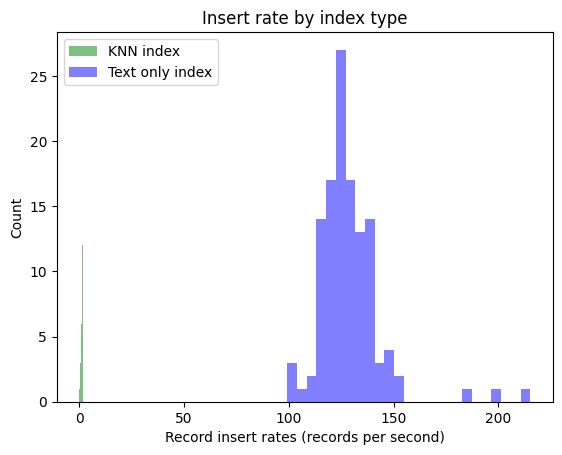

Estimated total text only insert time: 44.5 hours
Mean text only insert rate: 129 records per second

Estimated total KNN insert time: 209.0 days
Mean KNN insert rate: 1.143 records per second



In [6]:
plt.title('Insert rate by index type')

plt.hist(
    knn_insert_rates,
    facecolor='green',
    label='KNN index',
    alpha=0.5,
    bins=25
)

plt.hist(
    text_insert_rates,
    facecolor='blue',
    label='Text only index',
    alpha=0.5,
    bins=25
)

plt.legend(loc = 'upper left')
plt.xlabel(f'Record insert rates (records per second)')
plt.ylabel('Count')
plt.show()

mean_text_insert_rate=sum(text_insert_rates)/len(text_insert_rates)
estimated_total_text_only_insert_time=estimated_total_chunks / mean_text_insert_rate
print(f'Estimated total text only insert time: {estimated_total_text_only_insert_time / (60*60):.1f} hours')
print(f'Mean text only insert rate: {mean_text_insert_rate:.0f} records per second\n')

mean_knn_insert_rate=sum(knn_insert_rates)/len(knn_insert_rates)
estimated_total_knn_only_insert_time=estimated_total_chunks / mean_knn_insert_rate
print(f'Estimated total KNN insert time: {estimated_total_knn_only_insert_time / (60*60*24):.0f} days')
print(f'Mean KNN insert rate: {mean_knn_insert_rate:.3f} records per second\n')

Yikes, that's not going to work. Looking at the difference in insert rates, it is clear that we were right about the bottleneck: it's definitely the embedding calculation/KNN. So, a few ideas here.

1. Though the GPUs are available inside the OpenSearch node Docker containers, OpenSearch is not using them... we should troubleshoot that.
2. We can insert batches with the bulk interface - if that means OpenSearch is calculating the embeddings in parallel, using a larger batch size might speed things up.
3. We could use multiple insert workers - just looking at htop, we are using less than 50% of available CPU resources while inserting, so we should be able to go faster.
4. Last would be reading up on OpenSearch cluster management in general to see if there are settings we should be tuning for this type of thing.

Think that getting the GPUs online is going to be the only real solution here. Given the amount of CPU we are already using while making/inserting embeddings we probably can't speed up much more than two-fold through parallelism alone.

Let's at least try bigger bulk batches first.

## 3. Insert rate: bulk insert batch size

In [15]:
# Bulk insert batch sizes to test
batch_sizes=[1,2,4,8,16,32,64,128,256]

# Replicates for each batch size
replicates=3

# Holder for results
results={}

# Ingest all of the sample text so we don't have to deal with
# nested loops over the input batches
texts=[]

# Loop on the input batches
for i in input_data['batches']:

    # Load the batch
    batch=input_data[f'batches/{i}']

    # Loop on the records in the batch
    for record in batch:

        # Decode the text
        text=record.decode('utf-8')

        # Collect the text
        texts.append(text)

print(f'Have {len(texts)} input records')

Have 51766 input records


Only need to test the KNN index rates here - that's what we are really after.

In [16]:
for batch_size in batch_sizes:
    print(f'\nRunning replicates for batch size {batch_size}')

    # Add the batch size to the results
    results[f'{batch_size}']=[]

    # Start an empty collector for the insert batch
    bulk_insert_batch=[]

    for replicate in range(replicates):
        print(f' Replicate {replicate}')

        # Loop on the input texts
        for text in texts:

            # Add it to the insert batch
            bulk_insert_batch.append(text)

            # Once we have enough records in the bulk insert batch, insert it
            if len(bulk_insert_batch) == batch_size:

                # Build the requests
                knn_requests=[]

                for text in bulk_insert_batch:

                    knn_request_header={
                        'update': {
                            '_index': knn_index_name,
                            '_id': record_num
                        }
                    }

                    knn_requests.append(knn_request_header)

                    request_body={
                        'doc': {
                            'text': text
                        },
                        'doc_as_upsert': 'true'
                    }

                    knn_requests.append(request_body)

                # Insert the record using the bulk interface. We are
                # indexing records one at a time here, but use bulk 
                # for consistency

                # Start the timer
                start_time=time.time()

                _=client.bulk(knn_requests)

                # Stop the timer and collect the insert rate
                dT=time.time() - start_time
                results[f'{batch_size}'].append(batch_size / dT)

                # Reset the bulk insert batch for the next round
                bulk_insert_batch=[]

                # Break out of the line loop
                break

            # If we have completed the desired number of replicates break out of the
            # inner loop to start the next batch size
            if len(results[f'{batch_size}']) == replicates:
                break


Running replicates for batch size 1
 Replicate 0
 Replicate 1
 Replicate 2

Running replicates for batch size 2
 Replicate 0
 Replicate 1
 Replicate 2

Running replicates for batch size 4
 Replicate 0
 Replicate 1
 Replicate 2

Running replicates for batch size 8
 Replicate 0
 Replicate 1
 Replicate 2

Running replicates for batch size 16
 Replicate 0
 Replicate 1
 Replicate 2

Running replicates for batch size 32
 Replicate 0
 Replicate 1
 Replicate 2

Running replicates for batch size 64
 Replicate 0
 Replicate 1
 Replicate 2

Running replicates for batch size 128
 Replicate 0
 Replicate 1
 Replicate 2

Running replicates for batch size 256
 Replicate 0
 Replicate 1
 Replicate 2


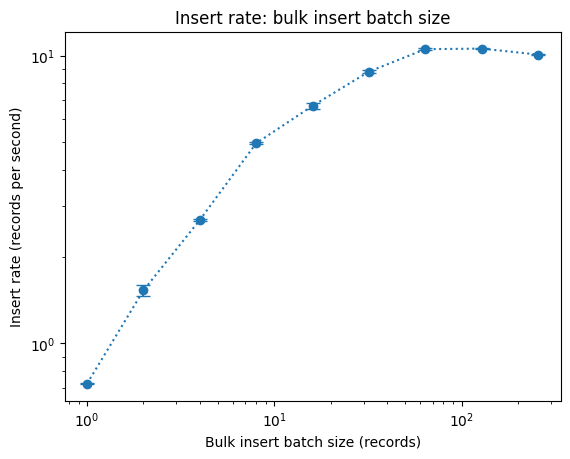

In [17]:
plt.title('Insert rate: bulk insert batch size')
plt.xlabel('Bulk insert batch size (records)')
plt.ylabel('Insert rate (records per second)')

standard_deviations=[]
means=[]

for batch_size in batch_sizes:
    times=results[f'{batch_size}']
    means.append(np.mean(times))
    standard_deviations.append(np.std(times))

plt.errorbar(
    batch_sizes, 
    means, 
    yerr=standard_deviations, 
    linestyle='dotted',
    marker='o', 
    capsize=5
)

plt.yscale('log')
plt.xscale('log')

plt.show()


OK, cool, looking at the graph, we can get a speed-up of on the order or 10x by increasing the bulk insert batch size. The gains start to saturate around a batch size of 64, let's calculate the estimated total insert time:

In [22]:
mean_insert_rate=sum(results['64']) / len(results['64'])
print(f'Estimated total insert time: {(estimated_total_chunks / mean_insert_rate) / (60*60*24):.1f} days')
print(f'Mean insert rate: {mean_insert_rate:.0f} records per second')

Estimated total insert time: 22.7 days
Mean insert rate: 11 records per second


Whelp, it is the ~10x speed up over single inserts to the KNN index that we were expecting from the graph - but it is still going to take three weeks to index the embeddings for all of Wikipedia. No more benefit to be had from parallelism here - CPU is pinned at 100% utilization on all cores. In fact, I'd like to cut it back so we can use the machine for other things during the run. Either way, we need another solution.

Two options I can think of:

1. Get the GPUs working with OpenSearch in Docker.
2. Pre-calculate the embeddings ourselves using the GPUs and then index them to OpenSearch.